### 라이브러리

In [10]:
# 라이브러리 불러오기

import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import re

pd.set_option("display.max_rows", None)   # 모든 행 출력
pd.set_option("display.max_columns", None)  # 모든 열 출력
pd.set_option("display.width", None)     # 줄바꿈 없이 넓게 출력
pd.set_option("display.max_colwidth", None)  # 셀 안의 긴 내용도 다 출력

In [11]:
# 한글 오류 제거 

import platform
import matplotlib.pyplot as plt

# 1. 한글 폰트 설정
if platform.system() == 'Darwin':  # Mac
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux (예: colab)
    plt.rcParams['font.family'] = 'NanumGothic'

# 2. 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

### 데이터 불러오기 및 전처리

In [12]:
# 광고 목록 테이블 불러오기
ads_list = pd.read_csv("df_list_clean.csv", usecols=['ads_idx', 'ads_limit','ads_payment','ads_edate','ads_type','ads_category', 'aff_idx', 'ads_name', 'ads_type', 'ads_category', 'ads_summary', 'ads_rejoin_type','ads_save_way'])

C:\Users\User\AppData\Local\Temp\ipykernel_13772\3100508715.py:2: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ads_list = pd.read_csv("df_list_clean.csv", usecols=['ads_idx', 'ads_limit','ads_payment','ads_edate','ads_type','ads_category', 'aff_idx', 'ads_name', 'ads_type', 'ads_category', 'ads_summary', 'ads_rejoin_type','ads_save_way'])


#### 광고 기간 결측치 채우기

In [13]:
ads_list['ads_edate'] = pd.to_datetime(ads_list['ads_edate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# 광고기간이 결측값인 행은 '2262-04-11'으로 채우기
# '2262-04-11' : pandas의 datetime64[ns]가 다룰 수 있는 범위
ads_list["ads_edate"] = ads_list["ads_edate"].fillna(pd.to_datetime("2262-04-11"))

#### 제휴사 광고 제외

In [14]:
# 제휴사 광고를 제외한 아이브 광고만 선택
# ads_list = ads_list[ads_list['aff_idx'] == 1]

#### 테스트 광고 제외

In [15]:
# 테스트 광고 수정 필요 -> 온리 테이트가 있다고 테스트 광고가 아님
is_test_ad = ads_list["ads_name"].str.contains("테스트|서비스종료|삭제", na=False, case=False)
is_valid_test_ad = ads_list["ads_name"].str.contains("브레인 테스트|게임테스트", na=False, case=False)
condition_to_delete = is_test_ad & ~is_valid_test_ad
ads_list = ads_list[~condition_to_delete].copy()

#### 광고제한 인코딩

In [16]:
ads_list['ads_limits'] = np.where(ads_list['ads_limit'].isnull(), 0, 1)

In [17]:
ads_list["ads_limits"].value_counts()

# 0 - 제한없음
# 1 - 제한있음

ads_limits
0    444529
1       543
Name: count, dtype: int64

#### 도메인 인코딩

In [18]:
# --- 분류 함수 (제외 키워드 적용) ---

def categorize_domain(ads_list, domain_name, keywords, search_cols, exclude_keywords=None):
    """
    DataFrame의 지정된 열(search_cols)에서 키워드를 찾아 
    새로운 도메인을 부여하는 함수입니다. (제외 키워드 적용)
    
    Args:
        ads_list (pd.DataFrame): 작업할 데이터프레임
        domain_name (str): 새로 부여할 도메인 이름 (예: '금융/보험')
        keywords (list): 찾을 키워드 리스트 (예: ['피싱', '보험'])
        search_cols (list): 키워드를 검색할 열 이름 리스트 (예: ['ads_name', 'ads_summary'])
        exclude_keywords (list, optional): 제외할 키워드 리스트 (예: ['고양이'])
        
    Returns:
        pd.DataFrame: 도메인이 추가된 데이터프레임
    """
    # 1. 키워드 리스트를 OR(|) 조건으로 묶어 하나의 검색 패턴으로 만듭니다.
    keyword_pattern = '|'.join(keywords)
    
    # 2. 검색할 모든 열을 대상으로 키워드가 포함되었는지 확인하는 전체 조건을 만듭니다.
    contains_keyword = ads_list[search_cols].apply(
        lambda col: col.str.contains(keyword_pattern, na=False)
    ).any(axis=1)
    
    # 3. 제외 키워드가 있을 경우, 제외 키워드가 포함된 행을 False로 처리
    if exclude_keywords is not None and len(exclude_keywords) > 0:
        exclude_pattern = '|'.join(exclude_keywords)
        contains_exclude = ads_list[search_cols].apply(
            lambda col: col.str.contains(exclude_pattern, na=False)
        ).any(axis=1)
    else:
        contains_exclude = pd.Series([False]*len(ads_list), index=ads_list.index)
    
    # 4. 'domain' 열이 비어있는(NaN) 행 중에서, 키워드가 포함되고, 제외 키워드는 포함되지 않은 행만 선택
    condition = (ads_list['domain'].isna()) & (contains_keyword) & (~contains_exclude)
    
    # 5. 해당 행의 'domain' 열에 새로운 도메인 이름을 채워 넣습니다.
    ads_list = ads_list.copy()  # 원본 데이터 보호
    ads_list.loc[condition, 'domain'] = domain_name
    
    print(f"✅ '{domain_name}' 카테고리 분류 완료! ({condition.sum()}개 적용, 제외 키워드: {exclude_keywords})")
    return ads_list

# --- 함수 사용 예시 ---

# 0. 먼저 'domain' 열을 생성하고 NaN으로 초기화합니다.
# ads_list가 정의되지 않은 경우를 대비하여 임의로 생성 (실제 사용 시에는 이 코드가 필요 없음)
# ads_list = pd.DataFrame({'ads_name': ['삼성전자', '아이폰'], 'ads_save_way': ['참여', '참여']})
ads_list['domain'] = np.nan

# 1. '금융/보험' 도메인 분류 실행 (제외 키워드: '고양이')
keywords_finance = ['금융','피싱', '보험', '주식', '펀드', '스탁', '신한', '머니트리카드', '공모주', 'KB', '업비트', '거래소', '환급금', '상조','더핀','증권','뱅크','보험료']
exclude_keywords_finance = ['고양이','차차차','중고차','Idle']
search_columns = ['ads_name', 'ads_save_way']
ads_list = categorize_domain(ads_list, '금융/보험', keywords_finance, search_columns, exclude_keywords=exclude_keywords_finance)


# 2. '게임' 도메인 분류 실행
keywords_game = [
    '게임', '스코어', '캐릭터', '서브퀘스트', '포커', '퍼즐', '라스트워', '피자 레디', 
    '복권', 'RAID', '머지아일랜더스', '키우기', 'Merge', 'Puzzle', '아케론', '다크엔젤',
    '악마단', 'RPG', '서바이벌', '라바', '모바일', '사전예약', '타이니팜', '이계밥', '타이쿤',
    '강쥐','2X','골목주방', '올바른고','철물파크','레벨','도달','달성','00점','원스토어','Idle','Lv.',
    '초이스 맞추기','클리어','에리어','빗썸','Complete','Tycoon','다이노 투 레이스','획득',
    '구역 해제','모으기','소울 로그','잠금 해제','외계 시대','좀비','붉은 도시', '코인피클', '디펜스', '디바인엣지','영웅줍줍','K데몬헌터스','조조의 꿈','편의점 정리왕 3D'
]
# 제외할 키워드 리스트를 정의합니다.
exclude_keywords_game = ['프리다이빙']

# 함수를 호출할 때 exclude_keywords 인자를 정확히 전달합니다.
ads_list = categorize_domain(
    ads_list, 
    '게임', 
    keywords_game, 
    search_columns, 
    exclude_keywords=exclude_keywords_game
)


# 3-1. '생활/쇼핑/이커머스_상품소비' 도메인 분류 실행
keywords_goods_consumption = [
    # 기존 키워드 유지 (삭제/수정 금지)
    # 식품/건강
    '로얄캐닌', '콜라겐', '흑염소', '콘드로이친', '비타민', '간식', '베지밀', '식품', '블랙마카', '절임배추', '뉴트리하루', '영양제', '천심련 아나파랙틴', '고려은단', '오쏘몰', '간장게장', '왕뚜껑 킹스브레이브', '헬스케어', '케어', '홈헬스',
    '바지락', '닭가슴살', '식단', '단백질', '제주농장', '진공포장', 'MSM', '글루타치온', '완도', '김',
    # 패션/뷰티
    '향수', '여신티켓', '화장품', '스나이델뷰티', '바바더닷컴', '팬츠',
    '목걸이', '가방', '슬링백', '반팔티', '보정속옷', '캔버스', '카프스킨', '립앤칙스', '멀티밤', '톤업크림', '크림샌드',
    # 리빙/인테리어
    '핸드타올', '방석', '오늘의집', '한샘몰', '바자르', '방향제', '네온라이트',
    '싱크대배수구', '배수통', '배수관', '방충망', '모기장', '하수구트랩', '도어스토퍼', '선반', '매트',
    # 디지털/가전
    'LG전자', '삼성닷컴', '몬스타기어', '몬스타pc스토어',' 전자',
    '공기청정기', '필터', '랜턴', '마사지기', '모기채', '카드단말기', '키오스크', '포스기', '터미널', '커피메이커', '드립포트', '전기그릴',
    # 반려동물
    '강아지', '애견', '고양이', '덴탈껌', '치약껌', '이동가방', '리터네코',
    # 기타 상품소비
    '연장체인', '대나무체인', '퍼퓸', '오드퍼퓸', '세트', '골프 퍼팩트맨', '부스터 마사지건', '알로에겔', '알로에', '폼클렌징', '영화할인권', '영화예매권', '보일러',
    # 신규 추가: 상품소비(구매) 관련 키워드
    '토스터기', '안마기', '티포트', '크림', '토너', '경주빵', '이어폰', '충전케이블', '베개', '카사바칩', '샘물', '에그트레이', '귀이개', '마사지건', '실내사이클', '분리수거함', '보조배터리', '밀대', '코인타올', '목난로',
    # 신규 추가: 샘플 데이터에서 추출된 상품소비(구매) 관련 키워드
    '토마스 풀 패밀리', '멀티 와이드 그릴', '뉴네이처 알티지오메가3파워', '황후지화', '다이어트커피', '체지방감소', '레오폴디 로봇청소기', '스텐밀폐용기', '그린바나나 정', '깐알밤', '아쿠아 부스트 옴므 올인원', '체중계', '빨래바구니', '쎈쏘팔메토', '순녹용 골드', '진공청소기', '다이렉트 다이어트N유산균', '발효흑삼고', '레몬밤 다이어트', '샤인 미스트', '요거트메이커', '피부관리기', '올포유', '캐리어', '에어 프라이어', '후라이팬', '오로라플러스플라즈마', '피톤치드 탈취제', '카무트 효소', '모로실', '쿨토시', '헤어 에센스', '와인잔', '접이식 카트', '홍삼정', '리챔', '돼지양념구이', '믹스웰 블랜더', '차전자피식이섬유분말스틱', '브랜드밀효소', '연어코프로테오글리칸프리미엄', '비타 이뮨 플래티넘 골드', '타우린L-아르기닌', '냄비', '셀 이펙터 세럼', '오트밀', '관절보단', '기억력개선', '스트롱 업 차전자피', '호박 진액', '발효홍삼 산삼배양근 활력진골드 앰플', '핸디스팀다리미', '코헴무선스팀다리미', '코힐밤', '마호가니 원형도마', '마호가니 사각도마', '에디번 전기 그릴', '멀티믹서기', '철갑상어 건강즙', '홍삼로얄젤리스틱', '6년근홍삼정에브리원', '로댕 쏘 화이트업 마스크팩', '이데베논 페롤릭 부스터 앰플', '발효구기자 차', '모로오렌지 C3G 프리미엄', '목동알탕', '목동 곤이알찜', '올플레임 IH 세라믹 후라이팬', '올플레임 IH 세라믹 궁중팬', '캐리어 기내용', '레디백', '헤어클리닉', '쎈류신에너지파워', '에브리원 헤어드라이어', '아쿠아 무드등가습기', '마뜨앙 여행용 기내형캐리어', '찹살떡', '설기', '퍼펙트 커버 쿠션''온열', '카트', '투표권', '가르시니아', '브로멜', '파인애플효소', '하루힘차', '여주해죽순돼지감자차', '당당컷', '라끄시안', '굿매너', '화장지', '뷰티앤소프트', '더화이트', '키친타올', '물티슈', '나틴다', '클렌징', '립스틱', '로션', '자연에서 온 녹차', '블랙앵거스', 'LA갈비', '소불고기', '돼지불고기', '라에스테', '퍼펙트 듀오', '샴푸', '트리트먼트', '드라이기', '인덕션', '에어프라이어', '세정티슈', '벌꿀', '헤어팩', '양말', '더플백', '진공 쌀통', '찜질박사', '주방세제', '세탁세제', '섬유유연제', '톱날과도', '기황단', '레몬즙', '오메가3', '락토페린', '브레인1088', '루테인', '허니로얄제리', '참진한 흑마늘', '칫솔', '이불', '패드', '바싹불고기', '냉감 패드', '냉감 바디필로우', '에어매쉬토퍼', '레몬자몽즙', '레자몽', '레티놀C', '짜장', '해물짬뽕', '홍삼진', '홍삼액진', '흑삼진액', '스팀 헤어팩', '헤어로스 세럼', '헤리티지', '셀 부스팅 니들', '카무트효소', '리놀렌산', '장어활력', '녹용', '아르기닌', '마카', '샬롱', '이지쿡', '글라스뷰', '스위스밀리터리', '이엔비', '인사덴탑', 'NMN', 'Tubble', '메디트리', '네이처프리', '코오롱제약', '보령파워', '코스모팜', '신꼬', '칸투칸', '독일 코겔', '햄토피아', '동의삼', '순수달', '밸런스어게인', '퍼니트', '맛다움', 'G마켓',
    # 신규 추가: 샘플 데이터 기반 추가 키워드 (기존 키워드와 중복 제외)
    '케라틴 키퍼', '액상 마그네슘', '콤부차', '복합유산균', '골드 앰플', '워터 글라이드', '프로바이오틱스', '유기농애사비스틱', '유기농레몬생강즙', '오트오브맘', '프로틴메이트', '아르간 에센스', '스트레이트 펌', '헤어앰플', '스프레이', '염모제', '귀리 오트오브맘', '쿠폰팩', '마늘후랑크', '동치미 물냉면', '곡물발효효소', '함흥냉면', '신라면', '치즈카츠', '천연펄프', '팔토시', '닭한마리 볶음탕', '캡슐세제', '팔목형', '손목형', '보양 추어탕', '귀리쌀죽', '선 스크린', '바른어묵', '우거지 뼈해장국', '소내장탕', '카무트 누룽지', '보풀제거기', '골드 등급 패키지', '실버 등급 패키지', '블랙 등급 패키지', '팥찜질팩', '규조토페인트','스탠드다리미',
    '가정용천국의계단','침구청소기','프랭클린 이염방지시트','젖병소독기','자차청정기','유럽미장',
    '규조토페인트','커리쉴', '루트 레미디', '스칼프 토닉', '프레시포레스트향', '소프트켄넬', '얼음조끼', 'homegrow', '창문열차단', '암막시트지', '발 받침대', '반팔 와이셔츠', '인감도장', '럭스엑스팟', '용가리', '목문용방문손잡이', '플로우아쿠아슈즈', '골프모자', '보스턴백', '건전지', '트램폴린', '남자셔츠', '쿠션커버', '오리젠사료오리지날', '골프피규어', '수면조끼', '베이포레소맥스', '쿠션', '볼마커', '라셀르간냉식', 'Modern High', '팜아크', '아크용접기', '바를 수딩 쿨링젤', '지아자연애장판', '유막제거제', '진정 앰플', '퍼팩트컴', '각인반지', '니트릴장갑', '부산국밥', '팰리세이드호환튜닝용품', '드리미 음식물처리기', '43인치스탠바이미', '휴나인 매스틱 검', '팰리세이드튜닝', '팰리세이드튜닝 c필러수납', '팰리세이드튜닝142', '팰리세이드 사이드스텝', '팰리세이드 쓰레기통 튜닝', '코인비엠에스', '갤럭시북K71AR', 'NT950XFT-A51A', '하주씨앤씨', '긱베이프 레전드3','루이보스티', '양배추즙', '토마토즙', '대추즙', '헛개진액', '수제청', '포스파티딜세린', '올리브오일', '미백마스크팩', '진정마스크팩', '유산균', '등산화깔창', '게이밍 컴퓨터의자', '디퓨저', '골프패치', '남자링거티', '기능성반팔 쿨 카라티', '즐거운가구 렌지대', 'NUTRALIFE 카테킨', '비엔엠코리아', '미마유모차', '에피소X', '블로커콤비블라인드', '엘리카', '벨벳', '엘라카테슬라', '테슬라', '오란다', '오토바이 자석 거치대', '바벨런스', '쿠션커버', '쿠션', '수면조끼', '팥찜질팩', '방수앞치마', '명함제작', '스티커제작', '드레이프블라우스', '꼬막', '방수앞치마', '유리문 도어락', '무타공 도어락', '모기퇴치기', '해충 퇴치기', 'Onliv', '잔더','롯데마트 제타', '락앤락', '동국제약', '닥터로니', '휴리엔', '백년약방', '네일로그', '안락의자', '리빙박스', '아이언커버', '와이셔츠', '블라우스', '한우사골곰탕', '곶감', 'usb', '청국장', '베누스타 청소기', '컴퓨터의자', '인테리어의자', '그로밋 키링', '해장국', '딸기칩', '개완', '티머그', '차총', '보이차', '구찌뽕 추출물', '백향과', '황토볼', '차열페인트', '곰팡이방지페인트', '결로방지페인트', '벽지페인트', '가정용미니에어건', '네오프렌구명조끼', '휴나인 애사비','삼성 G100','삼성 H170D','삼성 F100D','키친플래그','제주탄산수',
    # 신규 추가: 분석된 상품소비 키워드
    '밴디 양방향 미끄럼방지 실내 욕실화', '삼성제약 내간에밀크씨슬실리마린', 'US 스킨아우라히알루론비타', 'US 프로바이오포스콜리500', '부사 사과', '스테비아 방울토마토', '천도복숭아', '하우스 감귤', '청사과', '프리미엄 파로', '백골뱅이', '대추 방울토마토', 'vintage', '체리 운드', '밤꿀', '네오디움 자석', '쉬폰커튼', '암막커튼', '코드스트랩', '스와들', '셀프페인트', '젯소', '페인트', '친환경페인트', '마이크로시멘트', '휘게로 페인트', '베스트에어컨 투인원', '여성 여름 셔츠', '치약', '피톤치드', '나노건', '피톤치드연무기', 'LCN마이코셉트', '업젤', '닭갈비', '오리주물럭', '프로파일','전자담배','논가스용접기',
    # 신규 추가: 분석된 데이터에서 상품소비로 분류할 키워드
    '볶은아몬드', '무선 쿨링 고데기', '골프트로피', '스탠맨해머전동드릴', '블루키워드', '리브라 에보', '유산지어', '지오 24MR400W 지오비전', '개밥청춘 위픽 에어드', '테이블야자', '떡볶이택배', '구운계란', '엘카라 프로폴리스', '크리스탈 감사패', '커피원두', '인섹트도그', '미마 모카색상 절충형유모차', '여행용 프리볼트 고데기', '수술복', '갤럭시S25케이스', '꼬리곰탕', '아론샵 홀드맥스 헤어젤', '루피는 참치마요', '야채참치', '밀크팡 산양유프로틴', '대추차', '27US550', '윈도우11', '닥터스초이스 콘드', '자전거라이트어', '자바라의자', '스탠드스팀다리미', '스팀다리미', '구강세정기', '제본', '산삼', '식물등', '테라리움', '책상 스탠드', '슬릿분', '백일상대여', '출차주의등', '수모', '도라지청', '환갑현수막', '칠순현수막', '관리기', '결명자차', '구기자차', '보리차 원액',
    # 신규 추가: 100행 데이터에서 확실한 상품소비 키워드
    '구운아몬드', '캐슈넛', '임산부효소', '업소용청소기', '아기잠옷', '아기파자마', 'PPF 왁스', '실내수영복', '용융소금', '스캇나인 아구아헤', '스타리온 대형 45박스 올냉장 냉장고', '전자저울', '멜라토닌', '감사패', '장수돌침대', '골프마스크팩', '교구장', '체리', '코튼 폴로 반팔니트', '코튼 반팔 폴로 여름니트', '차거름망', '곰탕육수', '씽크어스 하트', '차판', '자숙문어', '메리네 라비앙독', '여성 반팔 셔츠', '샤인머스켓', '오토바이리스', '양갈비', '까렌다쉬샤프', '잔디깎기', '하수구 뚫는 기계', '메탈지그', '청양고추', '예초기', '배달오토바이리스', '오리젠사료', '시트지제작', '우정링', '커플팔찌', '홍삼음료', '클립온 선글라스', '노시부석션팁', '닥터커피', '아몬드', '안전벨트', '건강하삼', '햄스터 케이지', 'ab슬라이드', '숙취해소제', '삼성ssd', '석재볼라드', '마사지젤', '가죽스티커', '콘체 블렌더',
    # 신규 추가: 83행 데이터에서 확실한 상품소비 키워드
    '메이튼 맥세이프자동차거치대', '베베끌레르 퍼펙트제로', '리플렛', '어닝', '방수액', '스트레치필름', '오토바이자석거치대', '핸드워시 답례품', '가죽트레이', '아만', '휴대폰 맥세이프 마그네틱 투명케이스', '어그 밴딩 슬리퍼', '손톱강화제', '까렌다쉬 샤프', '메탈파일', '원두커피', '인형뽑기기계', '일본지게차', '피오렌자또', '씨메커피머신', '토삭스', '파고라', '패션뷰티몰', '세레스쥬얼리',
    '최대 77% 할인. 럭키세븐 특가','29cm', '상품찜','JONS 신규 가입 혜택','참소라', '글루어트', '새미쥬얼리', '조개구이', '초코파이','나물짤순이'
]
exclude_keywords_goods_consumption = ['연남동 스튜디오']
ads_list = categorize_domain(
    ads_list,
    '상품소비',
    keywords_goods_consumption,
    search_columns,
    exclude_keywords=exclude_keywords_goods_consumption
)

# 3-2. '생활/쇼핑/이커머스_생활서비스' 도메인 분류 실행
keywords_life_service = [
    # 기존 키워드 유지 (삭제/수정 금지)
    # 교육/부동산
    '교육', '학습', '영어', '보카', '홈런', '온리원', '부동산', '경매', '기출문제', '학원',
    # 여행/문화
    '호텔', '하나투어', '골프네임택', '스마트캐디', '프리다이빙',
    # 생활서비스
    '운동', '휘트니스', '테라피', '캠핑', '물구나무', '운동기구', '참여신청', '달다방',
    # 신규 추가: 회원가입(서비스) 관련 키워드
    '회원가입', '서비스 가입', '라이프플러스', '트라이브', 'H.Point 회원 가입하기',
    # 샘플 데이터에서 추출된 생활서비스 관련 키워드
    '공용 화장실 해제','이혼전문변호사',
    # 신규 추가: 샘플 데이터 기반 추가 키워드 (기존 키워드와 중복 제외)
    '최초 오픈', '기부완료', '쿠폰팩 가입', '인터넷신규가입','Shipping','패러글라이딩', '일상비일상의틈', 'NOL', 'NOL (신규회원 국내숙소 특별할인)', '최초 오픈', '정답입력',
    # 추가: 리뷰 전체보기 클릭 후 URL 제출, 스토어 알림받기, 명소찾기
    '리뷰 전체보기 클릭 후 URL 제출', '스토어 알림받기', '명소찾기',
    # 신규 추가: 분석된 생활서비스 키워드
    '상세페이지제작', '비상주사무실',  'V컬러링 이용권',
    # 신규 추가: 100행 데이터에서 확실한 생활서비스 키워드
    '로고제작',
    # 신규 추가: 83행 데이터에서 확실한 생활서비스 키워드
    '특수청소', '전단지배포및제작','바카르','젤톡스','SK브로드밴드'
]
exclude_keywords_life_service = []
ads_list = categorize_domain(
    ads_list,
    '생활서비스',
    keywords_life_service,
    search_columns,
    exclude_keywords=exclude_keywords_life_service
)

# 3-3. '생활/쇼핑/이커머스_플랫폼' 도메인 분류 실행
keywords_platform = [
    # 기존 키워드 유지 (삭제/수정 금지)
    '쿠팡', '아이템매니아', '중고거래', '백화점', '당근마켓', '동네GS', 'GS25', '배달의민족',
    # '네이버스마트스토어',
    # 샘플 데이터에서 추출된 플랫폼 관련 키워드
    'G마켓',
    # 신규 추가: 에누리 가격비교, 네이버 쇼핑, 네이버 상품 해시태그, 상품 태그 맞추기
    '에누리 가격비교', '네이버 쇼핑', '네이버 상품 해시태그', '상품 태그 맞추기',
    # # 신규 추가: 분석된 플랫폼 키워드
    # '최대 77% 할인. 럭키세븐 특가',
    # # 신규 추가: 100행 데이터에서 확실한 플랫폼 키워드
    # '29cm', '상품찜',
    # # 신규 추가: 83행 데이터에서 확실한 플랫폼 키워드
    # 'JONS 신규 가입 혜택', '바카르'
]
exclude_keywords_platform = []
ads_list = categorize_domain(
    ads_list,
    '플랫폼',
    keywords_platform,
    search_columns,
    exclude_keywords=exclude_keywords_platform
)

# 아래는 분류가 애매하거나 추가 검토가 필요한 항목 리스트입니다.
# 분류가 애매한 항목 (키워드로 분류가 어려운 경우)
# - 퀴즈 맞추기, 퀴즈 정답 맞추기, [퀴즈] ~, ~맞추기, [정답] ~, 클릭, 받기, 상세페이지제작, 대전 비상주사무실, [간편참여] 특가요정, 강재인 (저장 후 주차장 URL), 다이아XXXX (저장 후 주차장 URL), 푸슈 (저장 후 주차장 URL), 일산보청기 (저장 후 주차장 URL), 미사 피부과 병원 미엘 (저장 후 주차장 URL), 수원중고차 (저장 후 주차장 URL), 인천제일바다낚시 (저장 후 주차장 URL), 라플로르드무아 (저장 후 주차장 URL), 창원세무사 조영빈 사무소 (저장 후 주차장 URL), 대전유리창청소 (저장 후 주차장 URL), 부천한방병원 차오름 (명소찾기), 강남수입차정비 내화모터스 (명소찾기), 이리와코리아 10개옵션 맞추기, 피지컬방이헬스 맞추기, 논가스용접기 200프로 맞추기, 유산지어 맞추기, 테이블야자 맞추기, 떡볶이택배 맞추기, 구운계란 인생 맞추기, 개밥청춘 위픽 에어드 맞추기, 우주인전자담배 맞추기, 지오 24MR400W 지오비전 맞추기, 엘카라 프로폴리스 맞추기, 크리스탈 감사패 맞추기, 인섹트도그7.5kg 맞추기, 잘봄XXX (저장 후 주차장 URL), [퀴즈] 강남 하수구뚫음, 삼성 F100D, 닥터초이스맞추기, 볶은아몬드, [퀴즈] 금천구 하수구막힘, 습자지 맞추기, [퀴즈] 무선 쿨링 고데기, 좋은상패26 닷컴 골프트로피 맞추기, 스탠맨해머전동드릴 맞추기, 블루키워드 맞추기, 동동마켓 리브라 에보 맞추기, 전자담배 액상(미성년자불가미션), 커피원두 맞추기, 상세페이지제작, 대전 비상주사무실, [정답] 치약(네이버 상품 상세내용) 등은 명확한 카테고리 분류가 어려워 추가 검토 필요
# - 닥터초이스맞추기, 삼성 F100D, 볶은아몬드, [퀴즈] 금천구 하수구막힘, 습자지 맞추기, [퀴즈] 무선 쿨링 고데기, 좋은상패26 닷컴 골프트로피 맞추기, 스탠맨해머전동드릴 맞추기, 블루키워드 맞추기, 동동마켓의 엘리카 핏 83 맞추기, 동동마켓의 엘리카 핏 60 맞추기, 동동마켓 리브라 에보 맞추기, 동동마켓 엘리카 니콜라테슬라 벨벳83 맞추기, 동동마켓의 벨벳60 맞추기, 동동마켓 엘라카테슬라 맞추기, 동동마켓 4구엘리카 테슬라 맞추기, 피지컬방이헬스 맞추기, 이리와코리아 10개옵션 맞추기, 미마유모차 절충형유모차 맞추기, 논가스용접기 200프로 맞추기, 유산지어 맞추기, 테이블야자 맞추기, 떡볶이택배 맞추기, 구운계란 인생 맞추기, 기능성반팔 쿨 카라티 무지 맞추기, 즐거운가구 렌지대1800 맞추기, NUTRALIFE 카테킨 맞추기, 비엔엠코리아 10개옵션 맞추기, 오란다, 바벨런스, 골프패치, 남자링거티, 지오 24MR400W 지오비전 맞추기, 우주인전자담배 맞추기, 등산화깔창, 진정마스크팩, 미백마스크팩, 유산균, 디퓨저, 양배추즙, 토마토즙, 대추즙, 헛개진액, 수제청, 포스파티딜세린, 올리브오일, 게이밍 컴퓨터의자, 꼬막, 방수앞치마, 유리문 도어락, 무타공 도어락, 모기퇴치기, 해충 퇴치기, 드레이프블라우스, 명함제작, 스티커제작, 잔더, Onliv, 스토어 알림받기, 아이티시스템 (저장 후 주차장 URL), 강재인 (저장 후 주차장 URL), 인천이혼전문변호사 (저장 후 주차장 URL), 다이아XXXX (저장 후 주차장 URL), 푸슈 (저장 후 주차장 URL), 일산보청기 (저장 후 주차장 URL), 미사 피부과 병원 미엘 (저장 후 주차장 URL), 수원중고차 (저장 후 주차장 URL), 인천제일바다낚시 (저장 후 주차장 URL), 라플로르드무아 (저장 후 주차장 URL), 창원세무사 조영빈 사무소 (저장 후 주차장 URL), 대전유리창청소 (저장 후 주차장 URL), 부천한방병원 차오름 (명소찾기), 강남수입차정비 내화모터스 (명소찾기), 에피소X XX출 (저장 후 주차장 URL), [간편참여] 특가요정, 락앤락 첫구매 이벤트, 상세페이지제작, 대전 비상주사무실
# Mr.Shipping (ads_name: Mr.Shipping, ads_save_way: 참여) : 어떤 카테고리인지 불분명, 추가 검토 필요
# Travel 포캐스트, 헬씨 포캐스트 (ads_save_way: 결제 및 콘텐츠 이용) : 콘텐츠/여행/서비스 등 복합적, 추가 검토 필요
# 사주링 맞추기, 닥터초이스맞추기, 스탠드다리미, 가정용천국의계단, 침구청소기, 패러글라이딩, 습자지 맞추기, 프랭클린 이염방지시트 맞추기, 해님 젖병소독기 맞추기, 해님UVLED젖병소독기4세대 맞추기, 에어힐러자차청정기 맞추기, 유럽미장, 유럽미장셀프, 규조토페인트, 등 "퀴즈 맞추기"류 : 콘텐츠/앱테크/기타 등 분류 애매, 추가 검토 필요
# 강재인, 인천이혼전문변호사, 다이아XXXX, 푸슈, 에피소X 등 (ads_save_way: 퀴즈 정답 맞추기, ads_name에 (저장 후 주차장 URL) 포함) : 분류 불명확, 추가 검토 필요
# - Mr.Shipping (참여, ads_name: Mr.Shipping) : 어떤 카테고리인지 불분명, 추가 검토 필요


# 5.'SNS/커뮤니케이션' 도메인 분류 실행
keywords_sns = ['페이스북', '인스타', '채팅', '친구', '동네', '소개팅', '데이팅', '골드스푼', '여보야', '팬더티비', '상담', '라임', '카페', '카카오톡', '후엠아이','여보랑','비긴즈','커넥트 CONNECT']
exclude_keywords_sns = []
ads_list = categorize_domain(ads_list, 'SNS/커뮤니케이션', keywords_sns, search_columns, exclude_keywords=exclude_keywords_sns)


# 7.'콘텐츠' 도메인 분류 실행
keywords_content = ['탑툰', '웹툰', '미툰', '미노벨', '운세', '워치페이스', '파일썬', '웹하드', '애니툰', '포춘텔러','꿀밤티비', '꿀물티비', '핑크티비','토정비결','굿툰','TikTok','나의 커리어 DNA','천신','성향매핑', '커플케미', '영화리뷰','멜론팔로우', '궁합', '포춘쿠키','홀스브릿지','영화 보스','회원가입 후 결제','KWDA','투표권 +','포캐스트','사주']
exclude_keywords_content = []
ads_list = categorize_domain(ads_list, '콘텐츠', keywords_content, search_columns, exclude_keywords=exclude_keywords_content)

# 8. '앱테크/리워드' 도메인 분류 실행
keywords_apptech = ['앱테크', '돈버는', '리워드어플', '오토링', '짤', '아이부자', 'Cash Giraffe', 'Cash Cow', '파블로', '서베이','MyB','돈 버는 미션','판도라박스', '도형그리기', '박스찾기', '시간잡기','서베이']
exclude_keywords_apptech = []
ads_list = categorize_domain(ads_list, '앱테크/리워드', keywords_apptech, search_columns, exclude_keywords=exclude_keywords_apptech)


# 10. '유틸리티/툴' 도메인 분류 실행
keywords_util = ['통화녹음', '익시오', 'AI', '뤼튼', '구독', '체크플러스']
exclude_keywords_util = []
ads_list = categorize_domain(ads_list, '유틸리티/툴', keywords_util, search_columns, exclude_keywords=exclude_keywords_util)

# 11. '지역/상점' 도메인 분류 실행
keywords_local = ['맛집', '식당', '점', '시장', '휘트니스', '쭈앤쭈', '족발선생',
'소곱판','박가네 빈대떡','풍년옥','철판집','청류','지도','플레이스','연남동',
'방이별관','카카오맵','공항', '클럽', '스튜디오','잠실','그래한의원','신의주찹쌀순대','라 스위스 서촌',
'의원','PT 청라','숙성회','서촌', '한의원', '순대', '쭈꾸미', '막국수','포항', '계곡', '테라피','캄왁싱','이지은웨딩','제주 이모카세',
'수성구 치과', '강남 하수구뚫음', '두정역 메이크업 속눈썹', '불당동 윤곽관리', '봉선동돼지갈비','제주 장어정식', '광주 첨단 갈매기살', '제주 외도동 물회', '외도동 횟집' ,'대전유리창청소', '한남동 인터내셔널 필라테스' , '수원중고차',
# 신규 추가: 미분류 데이터에서 추출된 지역/상점 키워드
'치과', '고깃집', '술집', '이자카야', '헬스장', '케이크', '가족사진', '맞춤정장', '요트투어', '보청기', '피부과', '병원', '미엘', '바다낚시', '세무사', '사무소', '유리창청소', '한방병원', '수입차정비', '모터스', '냉면', '숙성명작', '평양냉면', '여수', '구미', '충주', '용산', '광안리', '진주', '가좌', '칠암동', '진해', '초천동', '진주혁신도시', '굴포천역', '수원역', '강서', '가정동', '일산', '인천', '달항아리', '청라', '부산', '동래역', '랍스타', '고양시', '중앙로', '노량진고시원', '안양 정형외과', '대구 정형외과', '경산시 중산동', '연남 초야', '구리 비뇨기과', '피지컬방이헬스', '경남 아파트']
exclude_keywords_local = []
ads_list = categorize_domain(
    ads_list, 
    '지역/상점', 
    keywords_local, 
    search_columns, 
    exclude_keywords=exclude_keywords_local
)

# 12. '기타' 도메인 분류 실행
# 기타 내부에 속하는 도메인 -> 보안, 뉴스
keywords_etc = ['뉴스','충청남도','다함께차차차','피싱', 'OTP', '안심', '스마트사인', '인증', '범죄알리미', '약속번호','원키퍼','렌트카',
'로그인보호서비스','차차차','보호','사람인','리본카','보안플러스','건강지키미','종합광고대행사','캐디톡','인크루트','네이버맵','정답 미션','붙임머리', '치료', '블로그', '마케팅','제로네이트','법무사','알바천국', '알바몬', '인터넷가입', '누수', '국무조정실','국가', '붙임머리', '치료', '블로그', '마케팅', '입주청소']
exclude_keywords_etc = []
ads_list = categorize_domain(
    ads_list,
    '기타',
    keywords_etc,
    search_columns,
    exclude_keywords=exclude_keywords_etc
)

# 이제까지 분류되지 않은(nan) 모든 행을 '기타'로 할당합니다.
ads_list.loc[ads_list['domain'].isna(), 'domain'] = '기타'


# --- 최종 결과 확인 ---
print("\n--- 분류되지 않은 데이터 개수 ---")
print(f"미분류 데이터: {ads_list['domain'].isna().sum()}개")

print("\n--- 전체 도메인 분류 현황 ---")
print(ads_list['domain'].value_counts())



print("\n--- 각 도메인별 샘플 데이터 ---")
for domain in ads_list['domain'].dropna().unique():
    print(f"\n✅ '{domain}'으로 분류된 데이터:")
    sample_data = ads_list[ads_list['domain'] == domain][['ads_name', 'domain']].head()
    print(sample_data)

C:\Users\User\AppData\Local\Temp\ipykernel_13772\2268697010.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '금융/보험' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ads_list.loc[condition, 'domain'] = domain_name


✅ '금융/보험' 카테고리 분류 완료! (1976개 적용, 제외 키워드: ['고양이', '차차차', '중고차', 'Idle'])
✅ '게임' 카테고리 분류 완료! (5325개 적용, 제외 키워드: ['프리다이빙'])
✅ '상품소비' 카테고리 분류 완료! (68743개 적용, 제외 키워드: ['연남동 스튜디오'])


C:\Users\User\AppData\Local\Temp\ipykernel_13772\2268697010.py:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lambda col: col.str.contains(keyword_pattern, na=False)


✅ '생활서비스' 카테고리 분류 완료! (63232개 적용, 제외 키워드: [])
✅ '플랫폼' 카테고리 분류 완료! (1017개 적용, 제외 키워드: [])
✅ 'SNS/커뮤니케이션' 카테고리 분류 완료! (3774개 적용, 제외 키워드: [])
✅ '콘텐츠' 카테고리 분류 완료! (382개 적용, 제외 키워드: [])
✅ '앱테크/리워드' 카테고리 분류 완료! (297개 적용, 제외 키워드: [])
✅ '유틸리티/툴' 카테고리 분류 완료! (637개 적용, 제외 키워드: [])
✅ '지역/상점' 카테고리 분류 완료! (82483개 적용, 제외 키워드: [])
✅ '기타' 카테고리 분류 완료! (4491개 적용, 제외 키워드: [])

--- 분류되지 않은 데이터 개수 ---
미분류 데이터: 0개

--- 전체 도메인 분류 현황 ---
domain
기타            217206
지역/상점          82483
상품소비           68743
생활서비스          63232
게임              5325
SNS/커뮤니케이션      3774
금융/보험           1976
플랫폼             1017
유틸리티/툴           637
콘텐츠              382
앱테크/리워드          297
Name: count, dtype: int64

--- 각 도메인별 샘플 데이터 ---

✅ '기타'으로 분류된 데이터:
               ads_name domain
0              리니지레드나이츠     기타
1  강철의함대:Ocean Overlord     기타
2              스노우 SNOW     기타
4                  하이마트     기타
6                오늘도 환생     기타

✅ '생활서비스'으로 분류된 데이터:
           ads_name domain
3   서머너즈 워: 천공의 아레나  생활서비스
5             

In [19]:
# domain_mapping 딕셔너리 직접 생성
domain_mapping = {
    '기타': 0,
    '상품소비': 1,
    '게임': 2,
    '생활서비스': 3,
    '금융/보험': 4,
    'SNS/커뮤니케이션': 5,
    '유틸리티/툴': 6,
    '지역/상점': 7,
    '콘텐츠': 8,
    '앱테크/리워드': 9,
    '플랫폼': 10
}

# 딕셔너리를 사용하여 'domain' 컬럼을 새로운 'domain_encoded' 컬럼으로 변환
ads_list['domain'] = ads_list['domain'].map(domain_mapping)

#### 광고 단계별 인코딩

In [20]:
# 광고 단계별 분류

conditions = [
    # 3단계: 최종 수익 창출 (구매, 게임(특정퀘스트))
    (ads_list['ads_type'].isin([9, 12])) | (ads_list['ads_category'].isin([5, 6, 10, 11])),
    # 2단계: 행동 유도 (설치, 실행, 참여, 퀴즈, 구독 등)
    (ads_list['ads_type'].isin([1, 2, 3, 7, 11])) | (ads_list['ads_category'].isin([1, 2, 3, 4, 7, 8])),
    # 1단계: 단순 노출 및 클릭
    (ads_list['ads_type'].isin([4, 5, 6, 8, 10]))
]
values = [3, 2, 1]

# 새로운 컬럼 생성
ads_list['ads_3step'] = np.select(conditions, values, default=0)

#### 광고 결제방식 인코딩

In [21]:
# 1. 기본적으로 모든 광고를 '무료(0)'로 설정하는 새로운 컬럼 'is_paid'를 만듭니다.
ads_list['ads_paid'] = 0

# 2. '유료'를 의미하는 조건들을 정의합니다.
# 조건 1: '유료', '구매', '결제' 같은 키워드가 포함된 경우
paid_keywords_mask = ads_list['ads_payment'].astype(str).str.contains('유료|구매|결제', na=False)

# 조건 2: 숫자 값으로 변환했을 때 0보다 큰 경우 (실제 금액이 적힌 경우)
numeric_payments = pd.to_numeric(ads_list['ads_payment'], errors='coerce')
positive_payment_mask = numeric_payments > 0

# 3. 위 두 조건 중 하나라도 만족하는 경우, 'is_paid' 값을 '유료(1)'로 변경합니다.
ads_list.loc[paid_keywords_mask | positive_payment_mask, 'ads_paid'] = 1

# 4. 기존 'ads_payment' 컬럼은 삭제하고, 새로 만든 'is_paid' 컬럼의 분포를 확인합니다.
ads_list = ads_list.drop(columns=['ads_payment'])
print(ads_list['ads_paid'].value_counts())

# 0은 무료
# 1은 유료

ads_paid
0    443131
1      1941
Name: count, dtype: int64


### 1년치 적립 데이터 불러오기 및 전처리

In [22]:
# 참여데이터 불러오기
ive_time_report = pd.read_csv("df_rpt_clean.csv")
ive_time_report['rpt_time_date'] = pd.to_datetime(ive_time_report['rpt_time_date'], format='%Y-%m-%d', errors='coerce')

# 클릭수보다 전환수가 더 많은 행 제거하기
ive_time_report = ive_time_report[ive_time_report['rpt_time_clk'] >= ive_time_report['rpt_time_turn']]

# 참여데이터 날짜별로 그룹화하기 -> 날짜, 매체 별 집계  (고려해야할 부분 : 광고고유키에 따른 집계가 필요한지)
#ive_time_report = ive_time_report.groupby(['rpt_time_date', 'ads_idx', 'mda_idx'], as_index=False).agg({'rpt_time_clk':'sum', 'rpt_time_turn':'sum', 'rpt_time_acost':'sum', 'rpt_time_earn':'sum'})

In [23]:
# 광고목록에 존재하는 광고만 아이브1년치_참여데이터에서 가져오기 (이미 종료된 광고까지)

# ads_list에 있는 ads_idx만 필터링 + ads_edate 붙이기
filtered_ive_time_report = (ive_time_report.merge(ads_list, on='ads_idx', how='inner'))

filtered_ive_time_report = filtered_ive_time_report.drop(columns=['ads_summary','ads_name','ads_save_way','ads_limit'], axis=1)

# 전환수 변환 시 행 수: 185,873
# 전환수 제거 시 행 수 : 183,619

#### 재참여 가능여부 인코딩

In [24]:
#11 재참여_가능여부 
mapping = {'NONE': 0, 'ADS_CODE_DAILY_UPDATE': 1, 'REJOINABLE': 2}
filtered_ive_time_report['ads_rejoin_type'] = filtered_ive_time_report['ads_rejoin_type'].map(mapping)

filtered_ive_time_report["ads_rejoin_type"].value_counts()

ads_rejoin_type
0    5679660
1    1024773
2      80980
Name: count, dtype: int64

#### 시간 파생변수 추가

In [25]:
final_df = filtered_ive_time_report.copy()

In [26]:
# 요일 추가 변수

final_df['dayofweek'] = final_df['rpt_time_date'].dt.dayofweek   # 요일 (0=월, 6=일)
final_df['is_weekend'] = (final_df['rpt_time_date'].dt.dayofweek >= 5).astype(int)  # 주말 여부 -> 주말=1, 평일=0

In [27]:
# 날짜 컬럼을 모델링을 위해 변경

final_df['year'] = final_df['rpt_time_date'].dt.year
final_df['month'] = final_df['rpt_time_date'].dt.month
final_df['day'] = final_df['rpt_time_date'].dt.day

In [28]:
# 'date' 컬럼 생성
final_df['date'] = pd.to_datetime(final_df[['year', 'month', 'day']])

# 각 광고 ID의 최초 적립 날짜를 찾아 'start_date' 컬럼에 저장
final_df['start_date'] = final_df.groupby('ads_idx')['date'].transform('min')

# 'start_date'를 기준으로 'week'를 다시 계산
# (현재 날짜 - 적립 날짜)의 일수 차이를 계산
final_df['days_from_start'] = (final_df['date'] - final_df['start_date']).dt.days

# 일수 차이를 7로 나누어 'week'를 계산
# 소수점 아래는 버리고, 0주차는 1주차로 변환
final_df['week'] = (final_df['days_from_start'] // 7) + 1

# 기존의 'date', 'days_from_start', 'start_date' 컬럼은 제거
final_df = final_df.drop(columns=['date', 'days_from_start', 'start_date'])

In [29]:
# 휴일 여부 피쳐
import holidays

# 1. 'year', 'month', 'day' 컬럼을 사용해 날짜(date) 컬럼을 만듭니다.
final_df['date'] = pd.to_datetime(final_df[['year', 'month', 'day']])

# 2. 대한민국 공휴일 객체를 생성합니다.
kr_holidays = holidays.KR()

# 3. 'date' 컬럼을 확인하여 공휴일이면 1, 아니면 0을 부여하는 'is_holiday' 컬럼을 생성합니다.
final_df['is_holiday'] = final_df['date'].apply(lambda x: 1 if x in kr_holidays else 0)

# 주말(is_weekend)과 공휴일(is_holiday)을 합쳐 'is_restday' 피처를 만들 수도 있습니다.
final_df['is_restday'] = ((final_df['is_weekend'] == 1) | (final_df['is_holiday'] == 1)).astype(int)

final_df.head()

,rpt_time_date,rpt_time_time,ads_idx,mda_idx,rpt_time_clk,rpt_time_turn,rpt_time_scost,rpt_time_acost,rpt_time_cost,rpt_time_earn,abuse_3,abuse_4,abuse_7,aff_idx,ads_type,ads_category,ads_edate,ads_rejoin_type,ads_limits,domain,ads_3step,ads_paid,dayofweek,is_weekend,year,month,day,week,date,is_holiday,is_restday
0,2024-07-27,0,4418,761,1,0,0,0,0,0,0,0,0,23,3,10,2262-04-11,0,0,4,3,1,5,1,2024,7,27,1,2024-07-27,0,1
1,2024-07-27,0,7377,213,1,0,0,0,0,0,0,0,0,8,11,3,2026-04-01,0,0,6,2,0,5,1,2024,7,27,1,2024-07-27,0,1
2,2024-07-27,0,7377,337,1,0,0,0,0,0,0,0,0,8,11,3,2026-04-01,0,0,6,2,0,5,1,2024,7,27,1,2024-07-27,0,1
3,2024-07-27,0,7377,496,1,1,230,230,180,180,0,0,0,8,11,3,2026-04-01,0,0,6,2,0,5,1,2024,7,27,1,2024-07-27,0,1
4,2024-07-27,0,7528,792,1,0,0,0,0,0,0,0,0,8,5,3,2262-04-11,0,0,5,2,0,5,1,2024,7,27,1,2024-07-27,0,1


In [30]:
final_df.head()

,rpt_time_date,rpt_time_time,ads_idx,mda_idx,rpt_time_clk,rpt_time_turn,rpt_time_scost,rpt_time_acost,rpt_time_cost,rpt_time_earn,abuse_3,abuse_4,abuse_7,aff_idx,ads_type,ads_category,ads_edate,ads_rejoin_type,ads_limits,domain,ads_3step,ads_paid,dayofweek,is_weekend,year,month,day,week,date,is_holiday,is_restday
0,2024-07-27,0,4418,761,1,0,0,0,0,0,0,0,0,23,3,10,2262-04-11,0,0,4,3,1,5,1,2024,7,27,1,2024-07-27,0,1
1,2024-07-27,0,7377,213,1,0,0,0,0,0,0,0,0,8,11,3,2026-04-01,0,0,6,2,0,5,1,2024,7,27,1,2024-07-27,0,1
2,2024-07-27,0,7377,337,1,0,0,0,0,0,0,0,0,8,11,3,2026-04-01,0,0,6,2,0,5,1,2024,7,27,1,2024-07-27,0,1
3,2024-07-27,0,7377,496,1,1,230,230,180,180,0,0,0,8,11,3,2026-04-01,0,0,6,2,0,5,1,2024,7,27,1,2024-07-27,0,1
4,2024-07-27,0,7528,792,1,0,0,0,0,0,0,0,0,8,5,3,2262-04-11,0,0,5,2,0,5,1,2024,7,27,1,2024-07-27,0,1


### 날짜와 광고 기준으로 그룹화

In [31]:
# 집계
grouping_keys = ['ads_idx','mda_idx','rpt_time_date']

agg_dict = {
    'ads_rejoin_type': ('ads_rejoin_type', 'first'),
    'domain': ('domain', 'first'),
    'ads_type': ('ads_type', 'first'),
    'ads_category': ('ads_category','first'),
    'ads_3step': ('ads_3step', 'first'),
    'year': ('year', 'first'),
    'month': ('month', 'first'),
    'day': ('day', 'first'),
    'ads_limits': ('ads_limits', 'first'),
    'ads_paid': ('ads_paid', 'first'),
    'is_restday': ('is_restday', 'first'),
    'rpt_time_clk': ('rpt_time_clk', 'sum'),
    'rpt_time_turn': ('rpt_time_turn', 'sum'),
    'rpt_time_acost': ('rpt_time_acost', 'sum'),
    'rpt_time_earn': ('rpt_time_earn', 'sum'),
}

final_grouped_df = final_df.groupby(grouping_keys, as_index=False).agg(**agg_dict)

### 파생변수

In [32]:
final_grouped_df.head()

,ads_idx,mda_idx,rpt_time_date,ads_rejoin_type,domain,ads_type,ads_category,ads_3step,year,month,day,ads_limits,ads_paid,is_restday,rpt_time_clk,rpt_time_turn,rpt_time_acost,rpt_time_earn
0,2595,54,2025-03-22,0,3,3,8,2,2025,3,22,1,0,1,86,11,10560,8360
1,2595,54,2025-03-23,0,3,3,8,2,2025,3,23,1,0,1,24,4,3840,3040
2,2595,54,2025-03-24,0,3,3,8,2,2025,3,24,1,0,0,24,5,4800,3800
3,2595,54,2025-03-25,0,3,3,8,2,2025,3,25,1,0,0,10,0,0,0
4,2595,54,2025-03-26,0,3,3,8,2,2025,3,26,1,0,0,9,1,960,760


In [33]:
# 조건: 전환(turn)은 0이 아니고, 매출(acost)은 1 이하인 경우
condition = (final_grouped_df['rpt_time_turn'] != 0) & (final_grouped_df['rpt_time_acost'] <= 1)

# 위 조건을 만족하는 행의 acost 값을 earn 값으로 변경
final_grouped_df.loc[condition, 'rpt_time_acost'] = final_grouped_df['rpt_time_earn']

In [34]:
# 수익
final_grouped_df["profit"] = final_grouped_df["rpt_time_acost"] - final_grouped_df["rpt_time_earn"]

In [35]:
# 수익률
final_grouped_df["profit_margin"] = final_grouped_df["profit"] / final_grouped_df["rpt_time_acost"]

In [36]:
# 전환당 비용 (cpa)
final_grouped_df["cpa"] = final_grouped_df["rpt_time_earn"] / final_grouped_df['rpt_time_turn']

# 전환당 매출 (rpa)
final_grouped_df["rpa"] = final_grouped_df["rpt_time_acost"] / final_grouped_df["rpt_time_turn"]

# 전환율 (cvr)
final_grouped_df["cvr"] = final_grouped_df["rpt_time_turn"] / final_grouped_df["rpt_time_clk"]

In [37]:
# 7일 이동평균 매출
final_grouped_df["revenue_m7"] = final_grouped_df.groupby('ads_idx')['rpt_time_acost'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
# 30일 매출 변동성
final_grouped_df["revenue_std30"] = final_grouped_df.groupby('ads_idx')['rpt_time_acost'].transform(lambda x: x.rolling(window=30, min_periods=1).std())

# 7일 이동평균 비용
final_grouped_df["cost_m7"] = final_grouped_df.groupby('ads_idx')['rpt_time_earn'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
# 30일 비용 변동성
final_grouped_df["cost_std30"] = final_grouped_df.groupby('ads_idx')['rpt_time_earn'].transform(lambda x: x.rolling(window=30, min_periods=1).std())

# 7일 이동평균 수익
final_grouped_df["profit_m7"] = final_grouped_df.groupby('ads_idx')['profit'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
# 30일 수익 변동성
final_grouped_df["profit_std30"] = final_grouped_df.groupby('ads_idx')['profit'].transform(lambda x: x.rolling(window=30, min_periods=1).std())

# 7일 이동평균 rpa
final_grouped_df["rpa_m7"] = final_grouped_df.groupby('ads_idx')['rpa'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
# 7일 이동평균 cpa
final_grouped_df["cpa_m7"] = final_grouped_df.groupby('ads_idx')['cpa'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

In [38]:
final_grouped_df.head()

,ads_idx,mda_idx,rpt_time_date,ads_rejoin_type,domain,ads_type,ads_category,ads_3step,year,month,day,ads_limits,ads_paid,is_restday,rpt_time_clk,rpt_time_turn,rpt_time_acost,rpt_time_earn,profit,profit_margin,cpa,rpa,cvr,revenue_m7,revenue_std30,cost_m7,cost_std30,profit_m7,profit_std30,rpa_m7,cpa_m7
0,2595,54,2025-03-22,0,3,3,8,2,2025,3,22,1,0,1,86,11,10560,8360,2200,0.208333,760.0,960.0,0.127907,10560.0,NaN,8360.000000,NaN,2200.000000,NaN,960.0,760.0
1,2595,54,2025-03-23,0,3,3,8,2,2025,3,23,1,0,1,24,4,3840,3040,800,0.208333,760.0,960.0,0.166667,7200.0,4751.757570,5700.000000,3761.808076,1500.000000,989.949494,960.0,760.0
2,2595,54,2025-03-24,0,3,3,8,2,2025,3,24,1,0,0,24,5,4800,3800,1000,0.208333,760.0,960.0,0.208333,6400.0,3634.501341,5066.666667,2877.313562,1333.333333,757.187779,960.0,760.0
3,2595,54,2025-03-25,0,3,3,8,2,2025,3,25,1,0,0,10,0,0,0,0,NaN,NaN,NaN,0.000000,4800.0,4364.218143,3800.000000,3455.006030,1000.000000,909.212113,960.0,760.0
4,2595,54,2025-03-26,0,3,3,8,2,2025,3,26,1,0,0,9,1,960,760,200,0.208333,760.0,960.0,0.111111,4032.0,4151.375676,3192.000000,3286.505743,840.000000,864.869932,960.0,760.0


In [39]:
final_grouped_df.fillna(0, inplace=True)

In [40]:
final_grouped_df.head()

,ads_idx,mda_idx,rpt_time_date,ads_rejoin_type,domain,ads_type,ads_category,ads_3step,year,month,day,ads_limits,ads_paid,is_restday,rpt_time_clk,rpt_time_turn,rpt_time_acost,rpt_time_earn,profit,profit_margin,cpa,rpa,cvr,revenue_m7,revenue_std30,cost_m7,cost_std30,profit_m7,profit_std30,rpa_m7,cpa_m7
0,2595,54,2025-03-22,0,3,3,8,2,2025,3,22,1,0,1,86,11,10560,8360,2200,0.208333,760.0,960.0,0.127907,10560.0,0.000000,8360.000000,0.000000,2200.000000,0.000000,960.0,760.0
1,2595,54,2025-03-23,0,3,3,8,2,2025,3,23,1,0,1,24,4,3840,3040,800,0.208333,760.0,960.0,0.166667,7200.0,4751.757570,5700.000000,3761.808076,1500.000000,989.949494,960.0,760.0
2,2595,54,2025-03-24,0,3,3,8,2,2025,3,24,1,0,0,24,5,4800,3800,1000,0.208333,760.0,960.0,0.208333,6400.0,3634.501341,5066.666667,2877.313562,1333.333333,757.187779,960.0,760.0
3,2595,54,2025-03-25,0,3,3,8,2,2025,3,25,1,0,0,10,0,0,0,0,0.000000,0.0,0.0,0.000000,4800.0,4364.218143,3800.000000,3455.006030,1000.000000,909.212113,960.0,760.0
4,2595,54,2025-03-26,0,3,3,8,2,2025,3,26,1,0,0,9,1,960,760,200,0.208333,760.0,960.0,0.111111,4032.0,4151.375676,3192.000000,3286.505743,840.000000,864.869932,960.0,760.0


### csv 파일 보내기

In [41]:
final_grouped_df.to_csv("final_grouped_df3.csv")

### 데이터 집계 확인

In [33]:
df = final_grouped_df[final_grouped_df["rpt_time_date"]=="2025-07-26"]

In [34]:
df["rpt_time_acost"].sum()

np.int64(28730775)

In [35]:
df["rpt_time_turn"].sum()

np.int64(27513)

In [36]:
final_grouped_df[final_grouped_df["rpt_time_acost"] < final_grouped_df["rpt_time_earn"]]["mda_idx"].unique()

array([58])

In [38]:
a= df[(df["domain"]==2) & (df["ads_3step"]==2)]

a["profit"].sum()

np.int64(551732)

### EDA 분석

### 피쳐 확인

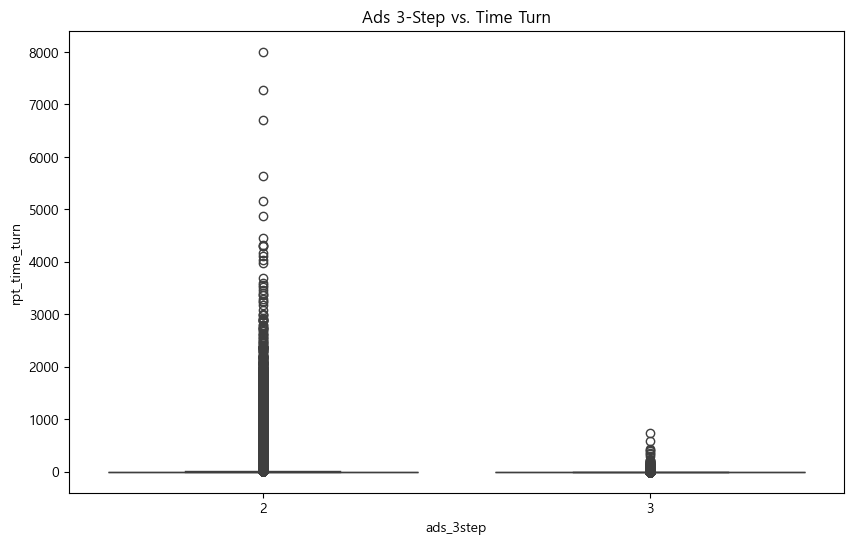

Box plot 'domain_vs_time_turn.png' created successfully.


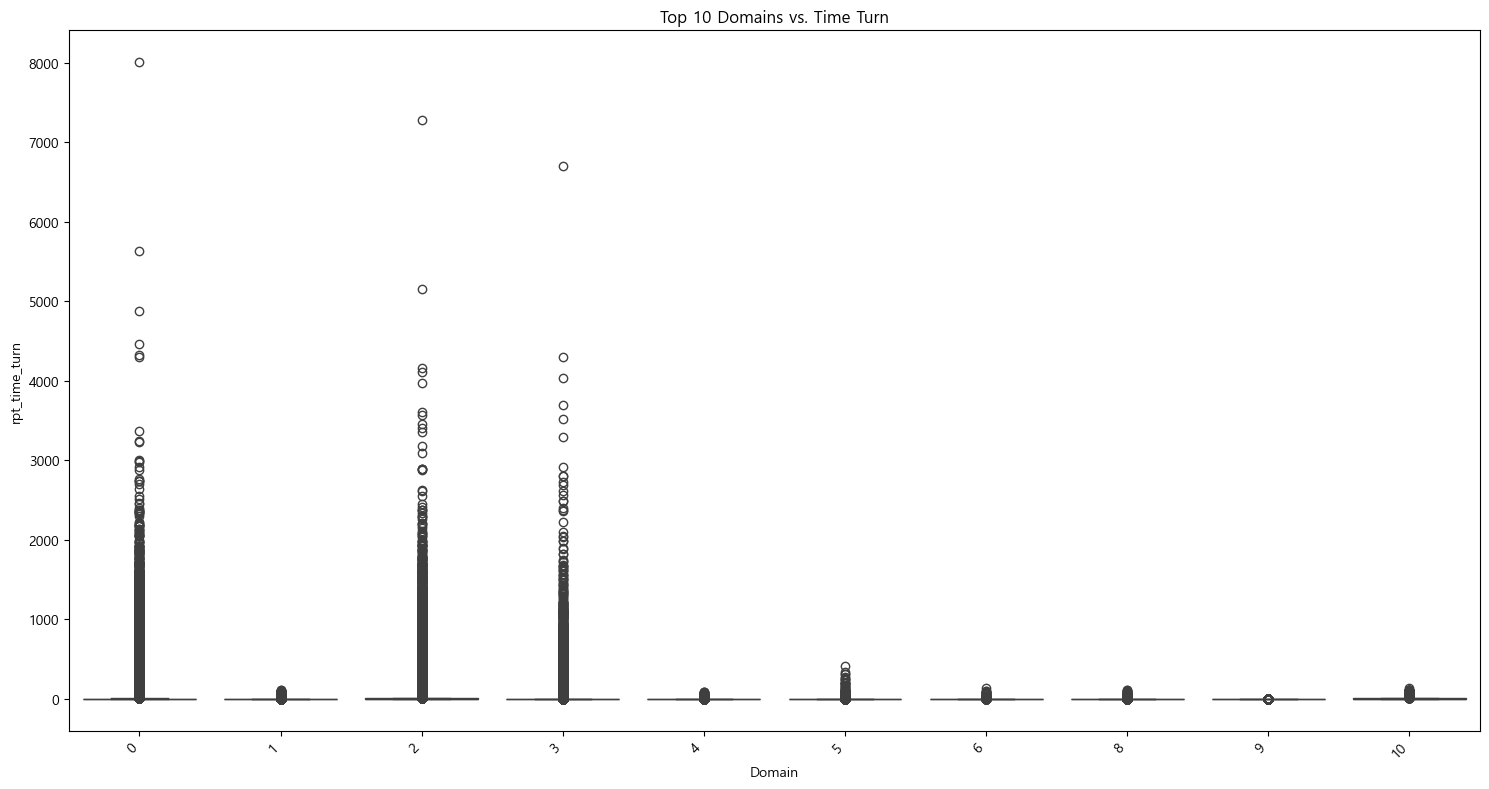

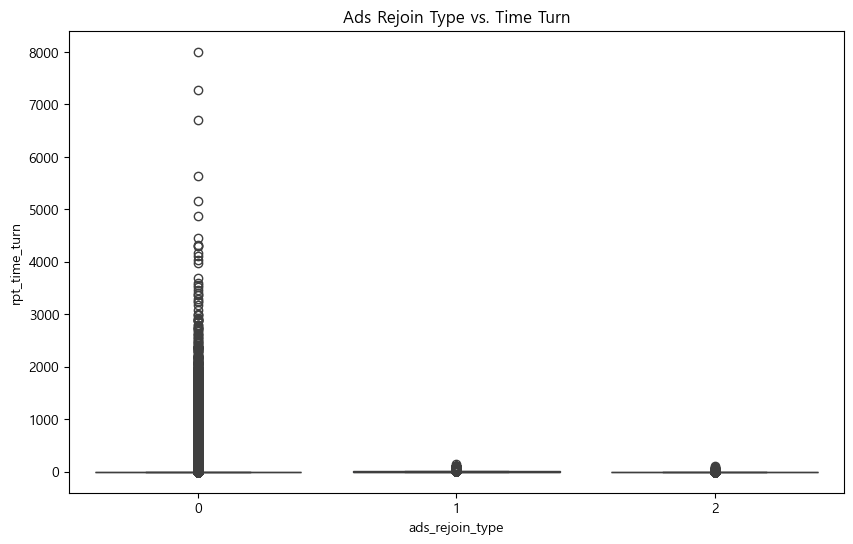

In [16]:
# ads_3step과 rpt_time_turn 관계
plt.figure(figsize=(10, 6))
sns.boxplot(x='ads_3step', y='rpt_time_turn', data=filtered_ive_time_report)
plt.title('Ads 3-Step vs. Time Turn')
plt.xlabel('ads_3step')
plt.ylabel('rpt_time_turn')
plt.show()

# domain 열에서 가장 빈번한 상위 10개 값을 추출
top_n_domains = filtered_ive_time_report['domain'].value_counts().nlargest(10).index

# 상위 10개 도메인에 해당하는 데이터만 필터링
filtered_top_domains = filtered_ive_time_report[filtered_ive_time_report['domain'].isin(top_n_domains)]

# 수정된 플롯 생성
plt.figure(figsize=(15, 8))
sns.boxplot(x='domain', y='rpt_time_turn', data=filtered_top_domains)
plt.title('Top 10 Domains vs. Time Turn')
plt.xlabel('Domain')
plt.ylabel('rpt_time_turn')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
print("Box plot 'domain_vs_time_turn.png' created successfully.")

# ads_rejoin_type와 rpt_time_turn 관계
plt.figure(figsize=(10, 6))
sns.boxplot(x='ads_rejoin_type', y='rpt_time_turn', data=filtered_ive_time_report)
plt.title('Ads Rejoin Type vs. Time Turn')
plt.xlabel('ads_rejoin_type')
plt.ylabel('rpt_time_turn')
plt.show()

### random forest + 가중치 (광고별 주차별)

In [ ]:
# 집계
grouping_keys = ['ads_idx', 'week']

agg_dict = {
    'ads_rejoin_type': ('ads_rejoin_type', 'first'),
    'domain': ('domain', 'first'),
    'ads_type': ('ads_type', 'first'),
    'ads_category': ('ads_category','first'),
    'ads_3step': ('ads_3step', 'first'),
    'year': ('year', 'first'),
    'month': ('month', 'first'),
    'rpt_time_turn': ('rpt_time_turn', 'mean'),
    'rpt_time_scost': ('rpt_time_scost', 'mean'),
    'rpt_time_acost': ('rpt_time_acost', 'mean'),
    'rpt_time_earn': ('rpt_time_earn', 'mean')
}

final_grouped_df = final_df.groupby(grouping_keys, as_index=False).agg(**agg_dict)

print(final_grouped_df.head())
print(f"새로운 데이터프레임 크기: {final_grouped_df.shape}")
print(f"데이터 타입: \n{final_grouped_df.dtypes}")

   ads_idx  week  ads_rejoin_type  domain  ads_type  ads_category  ads_3step  \
0     9935     1                0       1         3             8          2   
1     9935     2                0       1         3             8          2   
2     9935     3                0       1         3             8          2   
3     9935     4                0       1         3             8          2   
4     9935     5                0       1         3             8          2   

   year  month  rpt_time_turn  rpt_time_scost  rpt_time_acost  rpt_time_earn  
0  2024      7       0.066667      100.000000      100.000000      80.000000  
1  2024      8       0.130719      196.078431      196.078431     156.862745  
2  2024      8       0.071856      107.784431      107.784431      86.227545  
3  2024      8       0.090909      136.363636      136.363636     109.090909  
4  2024      8       0.100671      151.006711      151.006711     120.805369  
새로운 데이터프레임 크기: (15935, 13)
데이터 타입: 
ads_idx  

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error, root_mean_squared_error

# [핵심 1] 사용자님이 원하시는 feature 리스트를 명확하게 지정합니다.
features = ['ads_idx', 'ads_rejoin_type', 'domain', 'rpt_time_acost', 'rpt_time_earn', 'ads_type', 'ads_category', 'ads_3step', 'week', 'year', 'month']
X = final_grouped_df[features]
y = final_grouped_df['rpt_time_turn']

print("--- 2단계: 주차 기준 초기 분리 ---")
# [핵심 2] 원하시는 주차 기준 분리 로직을 적용합니다.
# 분리를 위해 X와 y를 임시로 합칩니다.
temp_df = pd.concat([X, y], axis=1)

ad_max_week = temp_df.groupby('ads_idx')['week'].max().reset_index()

train_ads_id = ad_max_week[ad_max_week['week'] >= 2]['ads_idx'].tolist()
test_ads_id = ad_max_week[ad_max_week['week'] < 2]['ads_idx'].tolist()

train_set = temp_df[temp_df['ads_idx'].isin(train_ads_id)].reset_index(drop=True)
test_set = temp_df[temp_df['ads_idx'].isin(test_ads_id)].reset_index(drop=True)

print(f"초기 train_set 크기: {train_set.shape}")
print(f"초기 test_set 크기: {test_set.shape}")
print("-" * 30)

print("--- 3단계: 8:2 비율 조정 ---")
# [핵심 2 계속] 훈련 데이터의 일부를 테스트 데이터로 옮겨 비율을 맞춥니다.
total_rows = len(temp_df)
target_train_rows = int(total_rows * 0.8)
current_train_rows = len(train_set)
needed_from_train_rows = current_train_rows - target_train_rows

print(f"훈련 데이터에서 테스트로 옮겨야 할 행의 수: {needed_from_train_rows}")

train_ads_shuffled = train_set['ads_idx'].unique()
np.random.shuffle(train_ads_shuffled)

ads_to_move_to_test = []
rows_moved = 0
for ad_id in train_ads_shuffled:
    # 훈련 세트에 여전히 남아있어야 할 광고 ID는 건너뜁니다.
    if len(train_set) - rows_moved > target_train_rows:
        ad_rows = len(train_set[train_set['ads_idx'] == ad_id])
        ads_to_move_to_test.append(ad_id)
        rows_moved += ad_rows
    
# 최종 훈련/테스트 데이터 분리
train_final_df = train_set[~train_set['ads_idx'].isin(ads_to_move_to_test)].reset_index(drop=True)
test_moved_df = train_set[train_set['ads_idx'].isin(ads_to_move_to_test)].reset_index(drop=True)
test_final_df = pd.concat([test_set, test_moved_df]).reset_index(drop=True)

# 최종 X, y 분리
X_train_final = train_final_df.drop(columns=['rpt_time_turn', 'ads_idx'])
y_train_final = train_final_df['rpt_time_turn']
print(X_train_final.head())
X_test_final = test_final_df.drop(columns=['rpt_time_turn', 'ads_idx'])
y_test_final = test_final_df['rpt_time_turn']

print(f"최종 X_train_final 크기: {X_train_final.shape}, y_train_final 크기: {y_train_final.shape}")
print(f"최종 X_test_final 크기: {X_test_final.shape}, y_test_final 크기: {y_test_final.shape}")
print("-" * 30)

print("--- 4단계: 가중치 적용 및 모델 학습 ---")
# [핵심 3] 가중치를 적용하여 모델을 학습합니다.
weight_multiplier = 10
sample_weights = np.where(y_train_final > 0, weight_multiplier, 1)
print(f"가중치가 {weight_multiplier}로 설정된 훈련 데이터 개수: {sum(sample_weights > 1)}")

def evaluate(model, X, y, name=""):
    predictions = model.predict(X)
    r2 = r2_score(y, predictions)
    mape = mean_absolute_percentage_error(y, predictions)
    rmse = root_mean_squared_error(y, predictions)
    print(f"\n{name} → R2: {r2:.4f}, MAPE: {mape:.2f}, RMSE: {rmse:.2f}")

rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42, n_jobs=-1)

print("가중치를 적용하여 모델 학습을 시작합니다...")
rf_model.fit(X_train_final, y_train_final, sample_weight=sample_weights)
print("모델 학습 완료!")

evaluate(rf_model, X_train_final, y_train_final, "Train")
evaluate(rf_model, X_test_final, y_test_final, "Test")

--- 2단계: 주차 기준 초기 분리 ---
초기 train_set 크기: (15770, 12)
초기 test_set 크기: (165, 12)
------------------------------
--- 3단계: 8:2 비율 조정 ---
훈련 데이터에서 테스트로 옮겨야 할 행의 수: 3022
   ads_rejoin_type  domain  rpt_time_acost  rpt_time_earn  ads_type  \
0                0       1      100.000000      80.000000         3   
1                0       1      196.078431     156.862745         3   
2                0       1      107.784431      86.227545         3   
3                0       1      136.363636     109.090909         3   
4                0       1      151.006711     120.805369         3   

   ads_category  ads_3step  week  year  month  
0             8          2     1  2024      7  
1             8          2     2  2024      8  
2             8          2     3  2024      8  
3             8          2     4  2024      8  
4             8          2     5  2024      8  
최종 X_train_final 크기: (12738, 10), y_train_final 크기: (12738,)
최종 X_test_final 크기: (3197, 10), y_test_final 크기: (3197,)
--

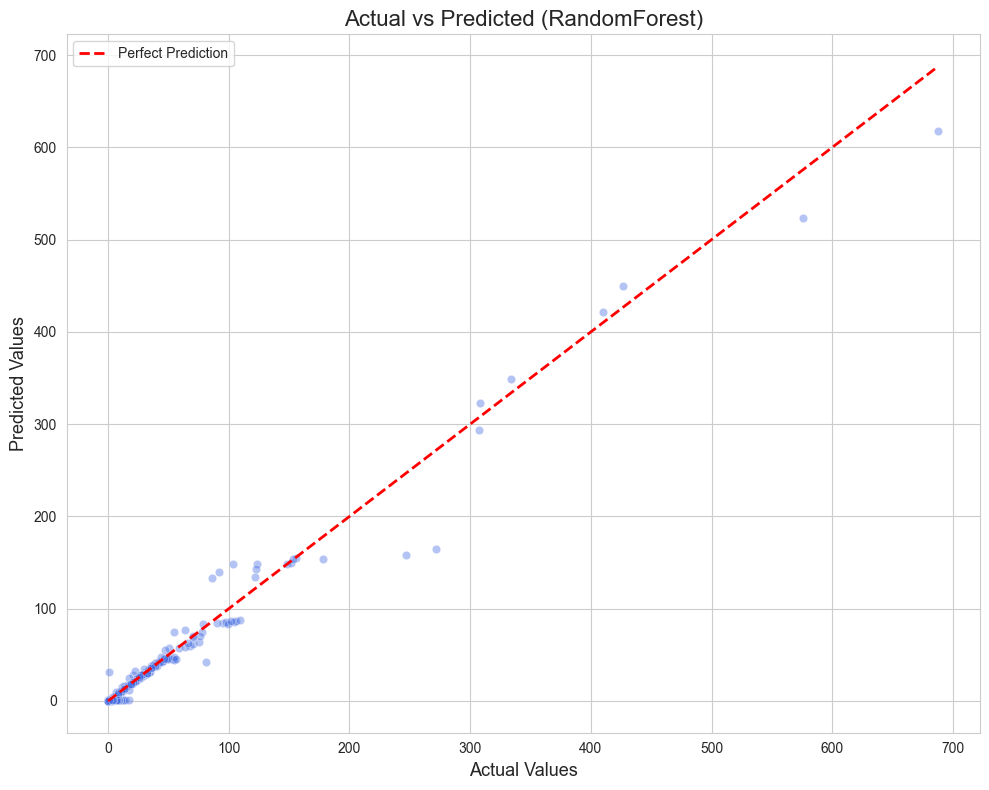

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 예측 (원본 값)
# rf_model은 원본 값을 예측하도록 훈련되었다고 가정합니다.
y_pred = rf_model.predict(X_test_final)
y_true = y_test_final

# 음수 예측값 처리
# 랜덤 포레스트는 음수 값을 예측할 수 있습니다. 이를 0으로 처리합니다.
y_pred[y_pred < 0] = 0

# 데이터프레임 생성
results = pd.DataFrame({
    'Actual': y_true,
    'Predicted': y_pred
})

# 시각화
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# 산점도 그리기
sns.scatterplot(
    x='Actual', y='Predicted', data=results,
    alpha=0.4, color='royalblue'
)

# 완벽한 예측선 (y = x)
min_val = min(results['Actual'].min(), results['Predicted'].min())
max_val = max(results['Actual'].max(), results['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.title('Actual vs Predicted (RandomForest)', fontsize=16)
plt.xlabel('Actual Values', fontsize=13)
plt.ylabel('Predicted Values', fontsize=13)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# X_train은 수치형 피쳐들만 포함된 DataFrame이라고 가정합니다.
# VIF 계산을 위해 LabelEncoder로 변환된 수치형 데이터를 사용합니다.
X_vif = X_train_balanced.copy()

# 각 피쳐의 VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# VIF 값이 높은 순으로 정렬
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# 결과 출력
print(vif_data)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

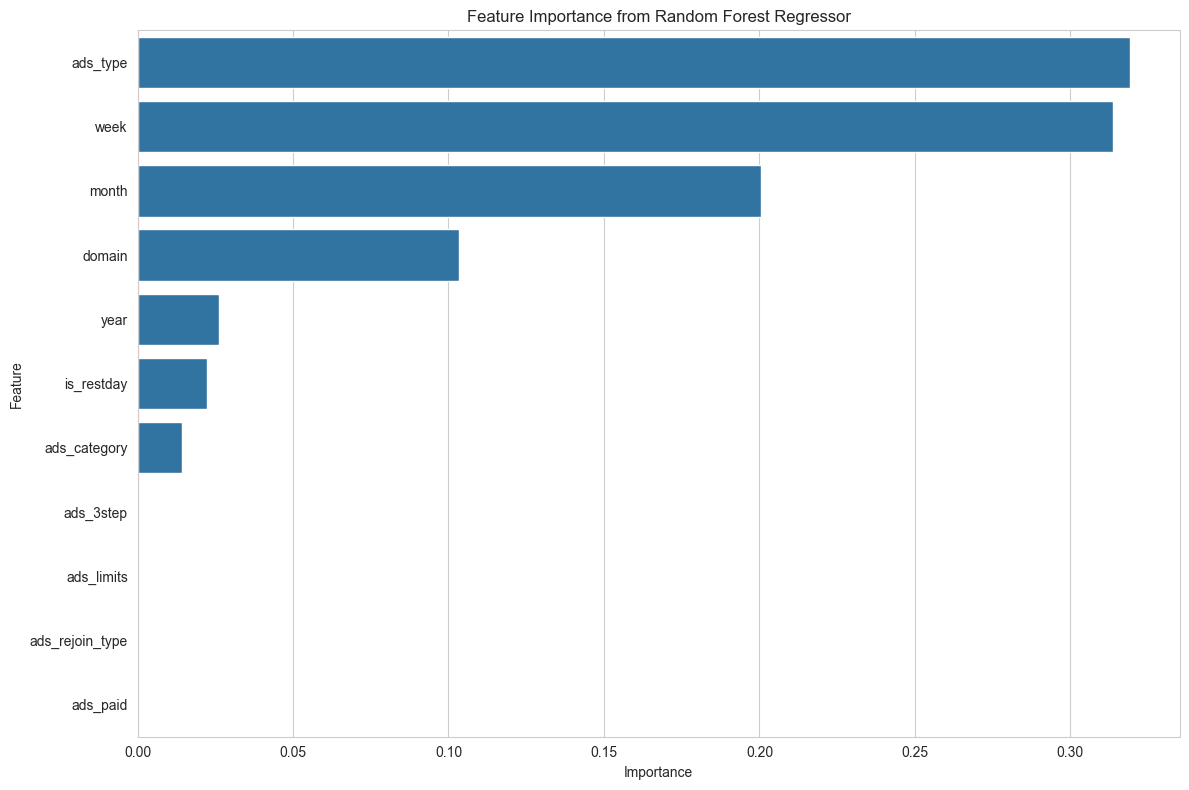

            Feature    Importance
3          ads_type  3.192693e-01
0              week  3.138265e-01
10            month  2.004161e-01
2            domain  1.032587e-01
9              year  2.623461e-02
6        is_restday  2.249071e-02
4      ads_category  1.417384e-02
5         ads_3step  2.755191e-04
8        ads_limits  4.703290e-05
1   ads_rejoin_type  7.447844e-06
7          ads_paid  3.310161e-07


In [26]:
# Feature importance 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 피쳐 임포턴스 추출
feature_importances = rf_model.feature_importances_
features = X_train_final.columns

# 데이터프레임으로 변환하여 정렬
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 정렬된 피쳐 임포턴스 출력
print(importance_df)